In [1]:
import pandas as pd
import numpy as np
import os

preprocessed_df = pd.read_csv('/content/drive/MyDrive/DDos_dataset.csv')

In [2]:
preprocessed_df.columns = preprocessed_df.columns.str.strip()
preprocessed_df

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,17,1,2,0,962.0,0.0,481.0,481.0,481.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
1,17,1,2,0,1174.0,0.0,587.0,587.0,587.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
2,17,1,2,0,1228.0,0.0,614.0,614.0,614.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
3,17,1,2,0,802.0,0.0,401.0,401.0,401.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
4,17,5,2,0,1488.0,0.0,744.0,744.0,744.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424972,6,26346,2,2,12.0,0.0,6.0,6.0,6.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
424973,6,1058092,4,2,24.0,0.0,6.0,6.0,6.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
424974,6,1053786,4,2,24.0,0.0,6.0,6.0,6.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
424975,6,77893,4,4,104.0,104.0,46.0,6.0,26.0,23.094011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [3]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import resample

def z_score(df):
  df_std = df.copy()
  for column in df_std.columns:
    if df_std[column].std() != 0:
      df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
    else:
      df_std[column] = 0
  return df_std

def preprocess_data(data):
  normalized_df = z_score(data.loc[:, data.columns != 'Label'])
  normalized_df['Label'] = data['Label']

  train_df, test_df = train_test_split(normalized_df, test_size=0.15, shuffle=True)
  temp = train_df.loc[:, train_df.columns != 'Label']
  X_train = temp
  y_train = train_df['Label']
  temp = test_df.loc[:, test_df.columns != 'Label']
  X_test = temp
  y_test = test_df['Label']
  return X_train, y_train, X_test, y_test

def sampling_data(data):
  temp = data.loc[:, data.columns != 'Label']
  X = temp
  y = data['Label']

  sampled_X, sampled_y = resample(X, y, n_samples=10000, random_state=42)
  X_train, X_test, y_train, y_test = train_test_split(sampled_X, sampled_y, test_size=0.2, random_state=42)
  return X_train, y_train, X_test, y_test


Accuracy: 0.869
Precision:  0.8903462316677386
Recall:  0.8563494794725167
F1-score:  0.8611045544441651
Confusion Matrix:


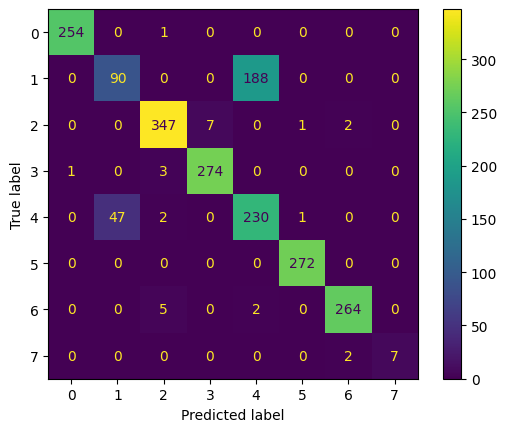

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

X_train, y_train, X_test, y_test = sampling_data(preprocessed_df)

# Create a random forest classifier with 100 trees
rfc = RandomForestClassifier(n_estimators=100)

# Fit the model to the training data
rfc.fit(X_train, y_train)

# Use the trained model to predict the test data
y_pred = rfc.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics to the console
print("Accuracy:", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

# Get the confusion matrix for the model
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_dis = ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test)

print("Confusion Matrix:")
print(conf_matrix_dis)

In [5]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 10.0 MB/s eta 0:00:00


In [6]:
import shap

explainer = shap.Explainer(rfc, X_train)
shap_values = explainer(X_train, check_additivity=False)

sum_value = None
for i in range(len(shap_values)):
  if sum_value is None:
    sum_value = np.abs(np.array(shap_values[i].values))
  else:
    sum_value += np.abs(shap_values[i].values)

mean_value = sum_value / 8000
print(mean_value[0])

top_features_indices = np.argsort(mean_value , axis=0)

result = []
for row in top_features_indices:
  result.append(np.mean(row))

top_features_indices = np.argsort(result)[-40:]

100%|===================| 63981/64000 [27:14<00:00]       

[0.01533178 0.01303186 0.00277065 0.00150755 0.00693483 0.01384901
 0.00464626 0.0005281 ]


In [7]:
top_features_indices

array([27, 53, 52, 39, 26, 29, 32,  9, 64, 44, 23, 61, 45, 35, 20, 21, 24,
       51, 31, 15, 43, 13, 55,  1, 66,  8, 54,  5, 50, 12, 16,  7, 14, 17,
       11,  4,  3, 10,  0,  2])

In [ ]:
column_names = X_train.columns[top_features_indices].tolist()

feature_selection = {}

for column in column_names:
  if column in feature_selection.keys():
    feature_selection[column] += 1
  else:
    feature_selection[column] = 1

feature_selection

{'Bwd IAT Max': 1,
 'Idle Mean': 1,
 'Subflow Fwd Packets': 1,
 'Fwd IAT Min': 1,
 'Packet Length Mean': 1,
 'Flow IAT Min': 1,
 'Bwd IAT Std': 1,
 'Init_Win_bytes_forward': 1,
 'Max Packet Length': 1,
 'Avg Fwd Segment Size': 1,
 'Idle Min': 1,
 'Active Std': 1,
 'Fwd Packet Length Mean': 1,
 'Down/Up Ratio': 1,
 'Average Packet Size': 1,
 'Subflow Fwd Bytes': 1,
 'Flow Bytes/s': 1,
 'Flow Duration': 1,
 'Active Min': 1,
 'Fwd Header Length': 1,
 'Fwd Packets/s': 1,
 'Bwd IAT Total': 1,
 'Bwd Packet Length Min': 1,
 'Packet Length Std': 1,
 'Flow IAT Max': 1,
 'Fwd IAT Std': 1,
 'Fwd Packet Length Min': 1,
 'Bwd Packet Length Mean': 1,
 'Bwd IAT Mean': 1,
 'Flow Packets/s': 1,
 'Active Mean': 1,
 'Total Fwd Packets': 1,
 'Bwd Packet Length Std': 1,
 'Total Backward Packets': 1,
 'Fwd Packet Length Std': 1,
 'Total Length of Bwd Packets': 1,
 'Fwd Packet Length Max': 1,
 'Bwd Packet Length Max': 1,
 'Protocol': 1,
 'Total Length of Fwd Packets': 1}

Accuracy: 0.8753509969096585
Precision:  0.8714163077683392
Recall:  0.8717829998558156
F1-score:  0.8559554423767992
Confusion Matrix:


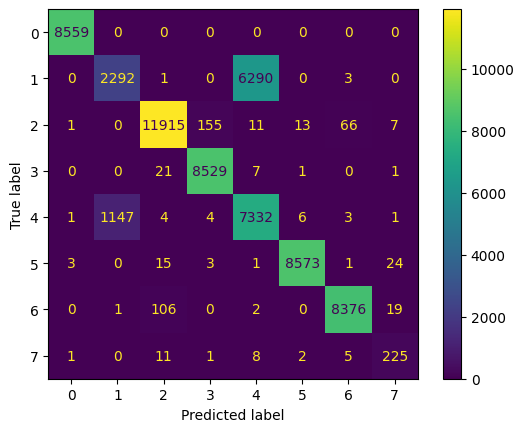

In [8]:
import xgboost as xgb
X_train, y_train, X_test, y_test = preprocess_data(preprocessed_df)

# Define XGBoost model
model = xgb.XGBClassifier(objective="multi:softmax", num_class=len(set(y_train)))

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics to the console
print("Accuracy:", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

# Get the confusion matrix for the model
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_dis = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

print("Confusion Matrix:")

In [12]:

importance = model.feature_importances_
feature_names = X_train.columns
sorted_idx = importance.argsort()[::-1]

print(importance)
for i, idx in enumerate(sorted_idx[:40]):
  print(feature_names[idx])
#   if feature_names[idx] in feature_selection.keys():
#     feature_selection[feature_names[idx]] += 1
#   else:
#     feature_selection[feature_names[idx]] = 1

# sorted_idx[:40]

[4.2239125e-04 3.9581038e-04 5.3746009e-04 2.2497577e-04 9.4823204e-03
 1.4133751e-04 3.7662808e-03 2.3311141e-03 6.2333969e-03 6.3483372e-02
 8.8567853e-05 1.9948007e-04 8.3199964e-05 1.3602180e-04 5.1054306e-04
 7.6777884e-04 1.9904118e-04 1.4169623e-04 1.2397017e-04 7.6718332e-04
 3.8591499e-04 6.3526859e-05 5.0190432e-05 5.4382457e-05 3.8883038e-04
 1.8447770e-04 1.9535240e-04 2.5201321e-04 1.5865528e-04 1.5029489e-04
 4.2232543e-05 4.5664501e-04 2.4234715e-04 1.1778640e-04 1.2383556e-04
 1.7565876e-01 2.7021654e-02 1.9187797e-04 3.2952448e-04 0.0000000e+00
 5.2188837e-04 0.0000000e+00 5.2258706e-01 8.9576349e-02 3.1047230e-04
 1.4586173e-04 2.5865834e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.2678134e-03
 2.0082864e-04 1.3419244e-04 1.1395490e-03 7.6560616e-05 5.8057827e-05
 9.3244198e-05 1.7329550e-04 6.8277142e-05 8.4184430e-05 0.0000000e+00
 7.4640775e-05 5.4517642e-02]
ACK Flag Count
Min Packet Length
URG Flag Count

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

X_train, y_train, X_test, y_test = preprocess_data(preprocessed_df)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

importances = rfc.feature_importances_
importance_df = pd.DataFrame({'Feature': list(X_train.columns), 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_30_features = importance_df.head(40)['Feature'].tolist()
top_30_features

# for feature in top_30_features:
#   if feature in feature_selection.keys():
#     feature_selection[feature] += 1
#   else:
#     feature_selection[feature] = 1

# feature_selection

['Min Packet Length',
 'Fwd Packet Length Min',
 'Avg Fwd Segment Size',
 'Fwd Packet Length Mean',
 'Average Packet Size',
 'Fwd Packet Length Max',
 'Packet Length Mean',
 'Max Packet Length',
 'Total Length of Fwd Packets',
 'ACK Flag Count',
 'Subflow Fwd Bytes',
 'Init_Win_bytes_forward',
 'Flow Bytes/s',
 'Inbound',
 'URG Flag Count',
 'Protocol',
 'Packet Length Std',
 'Flow IAT Mean',
 'Fwd Packet Length Std',
 'act_data_pkt_fwd',
 'Total Backward Packets',
 'Packet Length Variance',
 'Subflow Bwd Packets',
 'Init_Win_bytes_backward',
 'Flow IAT Max',
 'Bwd Header Length',
 'Fwd Packets/s',
 'Flow Duration',
 'Bwd Packets/s',
 'Flow Packets/s',
 'Subflow Fwd Packets',
 'Bwd IAT Max',
 'Flow IAT Std',
 'Fwd IAT Mean',
 'CWE Flag Count',
 'Fwd IAT Max',
 'Fwd IAT Total',
 'Total Fwd Packets',
 'Fwd IAT Min',
 'Bwd Packet Length Mean']

In [ ]:
feature_list = []
for f in feature_selection:
  if feature_selection[f] >1:
    feature_list.append(f)

len(feature_list)

42

In [ ]:
X_train, y_train, X_test, y_test = preprocess_data(preprocessed_df)

X_train = X_train[feature_list]
X_test = X_test[feature_list]

X_train.to_csv('/content/drive/MyDrive/Dataset/X_train2.csv')
y_train.to_csv('/content/drive/MyDrive/Dataset/y_train2.csv')
X_test.to_csv('/content/drive/MyDrive/Dataset/X_test2.csv')
y_test.to_csv('/content/drive/MyDrive/Dataset/y_test2.csv')

In [ ]:
X_train